This is the first try on implementing a LSTM on this project.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Semilla fija para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [24]:
# Cargar archivo unificado
df = pd.read_csv("oferta_academica_unificada.csv")

# Eliminar filas sin datos clave
df = df.dropna(subset=['Materia', 'Total_Cupos', 'semestre_numerico'])

# Codificar materia
le = LabelEncoder()
df['materia_codificada'] = le.fit_transform(df['Materia'])

# Guardar mapeo seguro
diccionario_materias = dict(zip(df['materia_codificada'], df['Materia']))

# Variables a escalar (sin codificar materia)
escalar = ['Total_Secciones', 'Residuos_Cupos', 'semestre_numerico', 'Total_Cupos']
scaler = MinMaxScaler()
df[escalar] = scaler.fit_transform(df[escalar])

# Features y target
features = ['materia_codificada', 'Total_Secciones', 'Residuos_Cupos', 'semestre_numerico']
target = 'Total_Cupos'


In [25]:
def crear_secuencias(data, pasos):
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i+pasos, :-1])
        y.append(data[i+pasos, -1])
    return np.array(X), np.array(y)

pasos = 3
X_total, y_total = [], []

for materia_id in df['materia_codificada'].unique():
    grupo = df[df['materia_codificada'] == materia_id].sort_values('semestre_numerico')
    valores = grupo[features + [target]].values
    if len(valores) > pasos:
        X_seq, y_seq = crear_secuencias(valores, pasos)
        X_total.append(X_seq)
        y_total.append(y_seq)

X = np.vstack(X_total)
y = np.concatenate(y_total)

print("✅ Secuencias creadas:", X.shape)


✅ Secuencias creadas: (184, 3, 4)


In [26]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(pasos, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=100, verbose=1)


Epoch 1/100
6/6 [==============================] - 1s 2ms/step - loss: 0.0383
Epoch 2/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0179
Epoch 3/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0104
Epoch 4/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 5/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 6/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 7/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 8/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 9/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 10/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 11/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 12/100
6/6 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 13/100
6/6 [==============================] - 0s 2ms/st

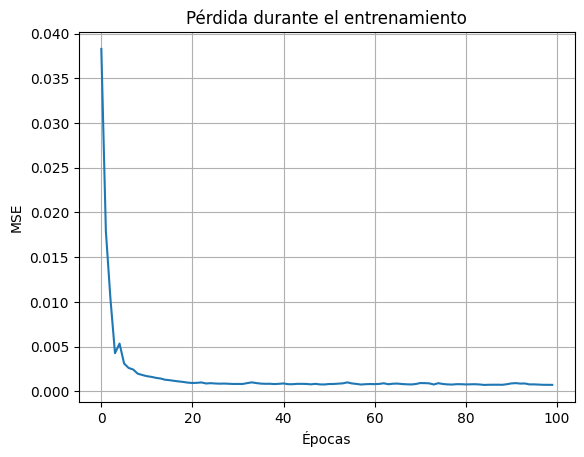

In [27]:
plt.plot(history.history['loss'])
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


In [28]:
predicciones = {}

for materia_id in df['materia_codificada'].unique():
    materia_df = df[df['materia_codificada'] == materia_id].sort_values('semestre_numerico')
    valores = materia_df[features + [target]].values

    if len(valores) >= pasos:
        secuencia = valores[-pasos:, :-1].reshape(1, pasos, len(features))
        y_pred = model.predict(secuencia)[0][0]

    
        ultima_fila_real = materia_df[escalar].values[-1].copy()
        ultima_fila_real[-1] = y_pred
        cupo_estimado = scaler.inverse_transform([ultima_fila_real])[0][-1]

        nombre_materia = diccionario_materias.get(materia_id, f"ID {materia_id}")
        predicciones[nombre_materia] = round(cupo_estimado)


1/1 [==============================] - 0s 12ms/step


In [29]:
df_pred = pd.DataFrame(list(predicciones.items()), columns=["Materia", "Cupos_Estimados"])
df_pred.to_excel("predicciones_cupos_proximo_semestre.xlsx", index=False)
print("✅ Archivo guardado: predicciones_cupos_proximo_semestre.xlsx")


✅ Archivo guardado: predicciones_cupos_proximo_semestre.xlsx


In [30]:
# Mostrar todas las predicciones
for materia, cupo in predicciones.items():
    print(f"{materia}: {cupo} cupos estimados")

ADMINISTRACION DE BASES DE DATOS: 122 cupos estimados
ADMINISTRACION DE REDES: 58 cupos estimados
ADMINISTRACION DE SERVIDORES: 100 cupos estimados
ALGORITMIA: 132 cupos estimados
ALMACENES DE DATOS (DATA WAREHOUSE): 108 cupos estimados
BASES DE DATOS: 147 cupos estimados
CLASIFICACION INTELIGENTE DE DATOS: 129 cupos estimados
COMPUTO FLEXIBLE (SOFTCOMPUTING): 54 cupos estimados
CONTROL DE PROYECTOS: 139 cupos estimados
ESTADISTICA Y PROCESOS ESTOCASTICOS: 307 cupos estimados
ESTRUCTURAS DE DATOS I: 27 cupos estimados
ESTRUCTURAS DE DATOS II: 56 cupos estimados
HIPERMEDIA: 117 cupos estimados
INGENIERIA DE SOFTWARE I: 67 cupos estimados
INGENIERIA DE SOFTWARE II: 71 cupos estimados
MATEMATICA DISCRETA: 44 cupos estimados
METODOS MATEMATICOS I: 204 cupos estimados
METODOS MATEMATICOS II: 183 cupos estimados
MINERIA DE DATOS: 92 cupos estimados
PROGRAMACION: 154 cupos estimados
PROGRAMACION PARA INTERNET: 290 cupos estimados
PROYECTO DE GESTION DE LA TECNOLOGIA DE INFORMACION: 25 cupos e